### Least Squares

##### Standard Problem:
$$
\begin{aligned}
\min_{x} \quad & \lVert x \rVert_2^2 \\
\textrm{s.t.} \quad & Ax = b
\end{aligned}
$$

##### Lagrangian:
$$
\begin{aligned}
\mathcal{L}(x, \lambda) = \min_{x} \max_{\lambda} \quad & x^{\top}x + \lambda^{\top} (Ax - b)
\end{aligned}
$$

##### Analytical Solution
$$
\begin{aligned}
\frac{\partial}{\partial \lambda} \rightarrow & Ax^\ast = b & (1) \\
\frac{\partial}{\partial x} \rightarrow & 2x^\ast + A^\top \lambda^\ast = 0 & \\
& x^\ast = - \frac{1}{2}A^\top\lambda^\ast & (2)
\end{aligned}
$$

Replace $x^\ast$ in $(1)$
$$
\begin{aligned}
A( - \frac{1}{2}A^\top\lambda^\ast) & = b \\
 - \frac{1}{2}AA^\top\lambda^\ast & = b \\
 \lambda^\ast = -2(AA^\top)^{-1}b
\end{aligned}
$$

Replace $\lambda^\ast$ in $(2)$
$$
x^\ast = A^\top(AA^\top)^{-1}b
$$

Experiment 1/10: {'n_eqs': 50, 'n_vars': 25, 'batch_size': 25, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 2/10: {'n_eqs': 50, 'n_vars': 25, 'batch_size': 50, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 3/10: {'n_eqs': 50, 'n_vars': 37, 'batch_size': 25, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 4/10: {'n_eqs': 50, 'n_vars': 37, 'batch_size': 50, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 5/10: {'n_eqs': 50, 'n_vars': 50, 'batch_size': 25, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 6/10: {'n_eqs': 50, 'n_vars': 50, 'batch_size': 50, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 7/10: {'n_eqs': 50, 'n_vars': 62, 'batch_size': 25, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 8/10: {'n_eqs': 50, 'n_vars': 62, 'batch_size': 50, 'primal_lr': 0.005, 'dual_lr': 0.005, 'n_epochs': 10000}
Experiment 9/10: {'n_eqs': 50, 'n_vars':

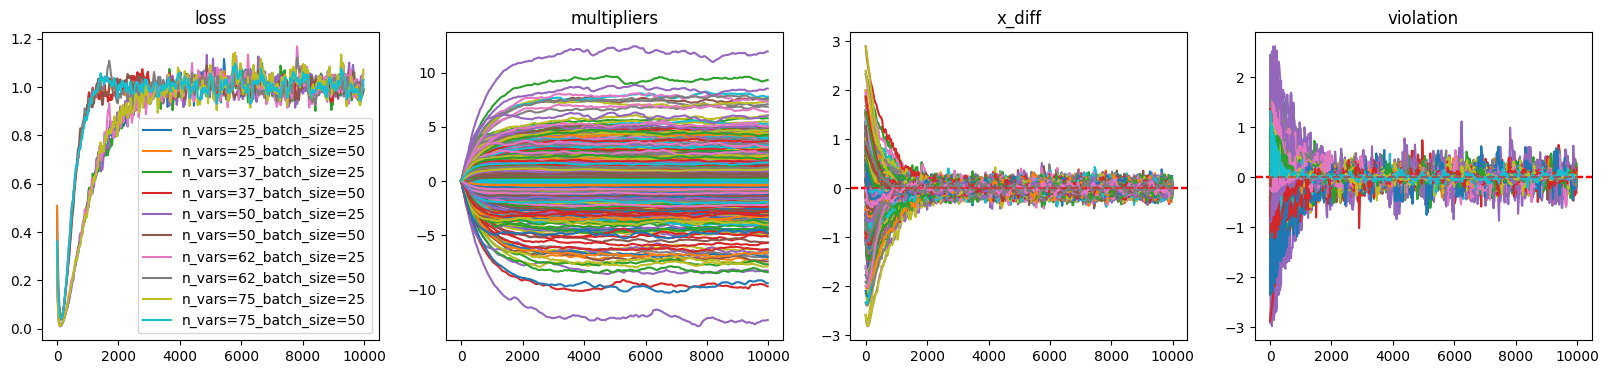

In [5]:
from typing import Tuple, Dict, Any, Union, List

import random

import cooper
import numpy as np
import torch

from cooper import CMPState, ConstraintGroup, ConstraintState
from cooper.optim import SimultaneousConstrainedOptimizer

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, BatchSampler

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class LinearConstraintSystem(Dataset):
    def __init__(self, A: torch.Tensor, b: torch.Tensor):
        self.A = A
        self.b = b

    def __len__(self):
        return self.A.shape[0]

    def __getitem__(self, index: list) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        index = torch.tensor(index, device=DEVICE)
        return self.A[index], self.b[index], index


class LeastSquares(cooper.ConstrainedMinimizationProblem):
    def __init__(self, eq_group: ConstraintGroup) -> None:
        self.eq_group = eq_group
        super().__init__()

    def compute_cmp_state(self, x: torch.Tensor, A: torch.Tensor, b: torch.Tensor, indices: torch.Tensor) -> CMPState:

        # FIX: consitency between functions
        loss = torch.linalg.vector_norm(x) ** 2
        violations = A @ x - b
        self.eq_group.state = ConstraintState(violation=violations, constraint_features=indices)

        return CMPState(loss=loss, observed_constraints=[self.eq_group])


def create_linear_system(n_eqs: int, n_vars: int):

    # Set seed for reproducibility
    torch.manual_seed(0)

    # Create random matrix
    initial_A = torch.randn(n_eqs, n_vars, device=DEVICE)
    U, _, V = torch.linalg.svd(initial_A)

    new_s = torch.zeros(n_eqs, n_vars, device=DEVICE)
    for i in range(min(n_eqs, n_vars)):
        new_s[i, i] = 1

    # Create new matrix with condition number 1
    A = torch.mm(U, torch.mm(new_s, V.T))

    # Create random vector
    dummy_x = torch.randn(n_vars, 1, device=DEVICE)

    # Generate b with x to guarantee a solution
    b = torch.mm(A, dummy_x)

    # Find optimal least squares solution using Pytorch
    x_optim = torch.linalg.lstsq(A, b).solution

    # Check if the solution is correct
    assert torch.allclose(torch.mm(A, x_optim), b, atol=1e-5)

    return A, b, x_optim


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def instantiate_dataloader(A: torch.Tensor, b: torch.Tensor, batch_size: int) -> DataLoader:

    # Instantiate Dataset
    linear_system = LinearConstraintSystem(A, b)

    # Create a dataloader that samples uniformly with replacement. Pass a generator and a
    # worker_init_fn to ensure reproducibility
    g = torch.Generator()
    g.manual_seed(0)

    # Create a random sampler and a batch sampler to sample the constraints uniformly with replacement
    random_sampler = RandomSampler(linear_system, replacement=True, generator=g)
    batch_sampler = BatchSampler(random_sampler, batch_size=batch_size, drop_last=False)

    # Create the dataloader
    dataloader_kwargs = {
        "sampler": batch_sampler,
        "worker_init_fn": seed_worker,
        "batch_size": None,  # Set batch_size to None to avoid additional dimension in the
        # output of the dataloader. The batch size is already specified
        # in the sampler so there is no need to specify it again.
    }

    return DataLoader(linear_system, **dataloader_kwargs)


def instantiate_cooper_variables(n_eqs: int, n_vars: int, primal_lr: float, dual_lr: float):

    # Create a constraint group for the equality constraints. We use a sparse constraint
    # to be able to update the multipliers only with the observed constraints (i.e. the
    # ones that are active in the current batch)
    eq_group = ConstraintGroup(constraint_type="eq", shape=n_eqs, dtype=torch.float32, device=DEVICE, is_sparse=True)

    # Define the problem with the constraint group
    cmp = LeastSquares(eq_group=eq_group)

    # Randomly initialize the primal variable and instantiate the optimizers
    x = torch.nn.Parameter(torch.rand(n_vars, 1, device=DEVICE))

    primal_optimizer = torch.optim.SGD([x], lr=primal_lr)  # , momentum=0.7)
    dual_optimizer = torch.optim.SGD(eq_group.multiplier.parameters(), lr=dual_lr)  # , momentum=0.7)

    optimizer = SimultaneousConstrainedOptimizer(
        constraint_groups=eq_group,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )

    return eq_group, cmp, x, optimizer


def _to_cpu_numpy(
    x: Union[torch.Tensor, list, dict[str, torch.Tensor]]
) -> Union[np.ndarray, list, dict[str, np.ndarray]]:

    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return [_to_cpu_numpy(v) for v in x]
    elif isinstance(x, dict):
        return {k: _to_cpu_numpy(v) for k, v in x.items()}
    else:
        raise ValueError(f"Unknown type: {type(x)}")


def solve_least_squares(
    constraint_loader: DataLoader,
    eq_group: ConstraintGroup,
    cmp: cooper.ConstrainedMinimizationProblem,
    x: torch.Tensor,
    optimizer: SimultaneousConstrainedOptimizer,
    x_optim: torch.Tensor,
    n_eqs: int,
    n_epochs: int,
) -> Dict[int, Dict[str, Union[float, np.ndarray]]]:

    # Optimal norm
    optimal_norm = x_optim.norm().item() ** 2

    # Run the optimization process
    state_history = {}
    for i in range(n_epochs):

        # Create empty tensor to accumulate the violation of the observed constraints
        acumulated_violation = torch.zeros(n_eqs, 1, device=DEVICE)

        for sampled_A, sampled_b, indices in constraint_loader:
            optimizer.zero_grad()
            cmp_state = cmp.compute_cmp_state(x, sampled_A, sampled_b, indices)
            _ = cmp_state.populate_lagrangian()
            cmp_state.backward()
            optimizer.step()

            # Accumulate the violation of the observed constraints
            acumulated_violation[indices] = cmp_state.observed_constraints[0].state.violation

        if i % 20 == 0:
            state_history[i] = {
                "loss": cmp_state.loss.item() / optimal_norm,
                "multipliers": _to_cpu_numpy(eq_group.multiplier.weight),
                "x_dif": _to_cpu_numpy(x - x_optim),
                "violation": _to_cpu_numpy(acumulated_violation),
            }

    return state_history


def pipeline(config: Dict[str, Any]):

    # Create a random linear system
    A, b, x_optim = create_linear_system(
        n_eqs=config["n_eqs"],
        n_vars=config["n_vars"],
    )

    # Instantiate the dataloader
    constraint_loader = instantiate_dataloader(
        A=A,
        b=b,
        batch_size=config["batch_size"],
    )

    # Instantiate the Cooper variables
    eq_group, cmp, x, optimizer = instantiate_cooper_variables(
        n_eqs=config["n_eqs"],
        n_vars=config["n_vars"],
        primal_lr=config["primal_lr"],
        dual_lr=config["dual_lr"],
    )

    # Run the optimization process
    state_history = solve_least_squares(
        constraint_loader=constraint_loader,
        eq_group=eq_group,
        cmp=cmp,
        x=x,
        optimizer=optimizer,
        x_optim=x_optim,
        n_eqs=config["n_eqs"],
        n_epochs=config["n_epochs"],
    )

    return state_history


def _stack_squeeze(x: np.ndarray) -> np.ndarray:
    return np.stack(x).squeeze()


def plot_results(
    state_history_list: List[Dict[int, Dict[str, Union[float, np.ndarray]]]], experiment_ids: List[str]
) -> None:

    _, ax = plt.subplots(1, 4, figsize=(20, 4))

    for state_history, experiment_id in zip(state_history_list, experiment_ids):

        # Plot the results
        iters, loss_hist, multipliers_hist, x_dif_hist, violation_hist = zip(
            *[(k, v["loss"], v["multipliers"], v["x_dif"], v["violation"]) for k, v in state_history.items()]
        )

        ax[0].plot(iters, loss_hist, label=experiment_id)
        ax[0].set_title("loss")

        ax[1].plot(iters, _stack_squeeze(multipliers_hist))
        ax[1].set_title("multipliers")

        ax[2].plot(iters, _stack_squeeze(x_dif_hist).squeeze())
        ax[2].set_title("x_diff")
        ax[2].axhline(0, color="red", linestyle="--", alpha=0.5)

        ax[3].plot(iters, _stack_squeeze(violation_hist))
        ax[3].set_title("violation")
        ax[3].axhline(0, color="red", linestyle="--", alpha=0.5)

    ax[0].legend(loc="lower right")

    plt.show()


n_experiments = 10
experiment_counter = 1
n_eqs = 50
quarter = n_eqs // 4

primal_lr = 5e-3
dual_lr = 5e-3

state_history_list = []
experiment_ids = []
for n_vars in [25, 37, 50, 62, 75]:
    for batch_size in [25, 50]:
        config = {
            "n_eqs": n_eqs,
            "n_vars": n_vars,
            "batch_size": batch_size,
            "primal_lr": primal_lr,
            "dual_lr": dual_lr,
            "n_epochs": 10000,
        }
        print(f"Experiment {experiment_counter}/{n_experiments}: {config}")
        experiment_counter += 1

        state_history = pipeline(config)
        state_history_list.append(state_history)
        experiment_ids.append(f"n_vars={n_vars}_batch_size={batch_size}")

plot_results(state_history_list, experiment_ids)